In [124]:
import numpy as np
import matplotlib.pyplot as plt

from tools.cpc import ConstantProductCurve as CPC, CPCContainer, T, CPCInverter, Pair
from tools.optimizer import CPCArbOptimizer, F, MargPOptimizer, PairOptimizer
from tools.analyzer import CPCAnalyzer
#print("{0.__name__} v{0.__VERSION__} ({0.__DATE__})".format(Pair))
print("{0.__name__} v{0.__VERSION__} ({0.__DATE__})".format(CPC))
#print("{0.__name__} v{0.__VERSION__} ({0.__DATE__})".format(CPCArbOptimizer))
print("{0.__name__} v{0.__VERSION__} ({0.__DATE__})".format(MargPOptimizer))
#print("{0.__name__} v{0.__VERSION__} ({0.__DATE__})".format(PairOptimizer))

plt.style.use('seaborn-v0_8-dark')
plt.rcParams['figure.figsize'] = [12,6]

ConstantProductCurve v3.4-1 (13/Dec/2023)
MargPOptimizer v5.3-4 (14/Dec/2023)


# Optimizer Testing [202312a-THOR-8044 Triangle]

**IMPORTANT NOTE** 

For the above imports to work, you must create a symlink to the `tools` module here, running

    ln -s ../../fastlane_bot/tools tools
    
Don't forget to add a local `.gitignore` file in this case!

## Reading input data

Set `curves_as_dicts` to the output of `CPCContainer.as_dicts`. The use `CPCContainer.from_dicts` to recreate a container.

In [125]:
curves_as_dicts = [{'k': 4.3078885616238194e+24,
  'x': 1250505254484.4102,
  'x_act': 0,
  'y_act': 344491.8061533139,
  'alpha': 0.5,
  'pair': 'USDC-eB48/THOR-8044',
  'cid': '74181555988764585035015664420125470098056-1',
  'fee': 2000.0,
  'descr': 'carbon_v1 THOR-8044/USDC-eB48 2000',
  'constr': 'carb',
  'params': {'exchange': 'carbon_v1',
   'tknx_dec': 18,
   'tkny_dec': 6,
   'tknx_addr': '0xa5f2211B9b8170F694421f2046281775E8468044',
   'tkny_addr': '0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48',
   'blocklud': 18758319,
   'y': 344491.8061533139,
   'yint': 344491.8061533139,
   'A': 0,
   'B': 1.659765242784964,
   'pa': 2.754820936639097,
   'pb': 2.754820936639097}},
 {'k': 1106096356.8039548,
  'x': 2619874.8519412754,
  'x_act': 2619874.8519412754,
  'y_act': 422.1943487049999,
  'alpha': 0.5,
  'pair': 'THOR-8044/WETH-6Cc2',
  'cid': '0xbf1875da0431343b56ec6295f706e257dbe85696e5270a5bdad005d37cc2fd9c',
  'fee': 0.003,
  'descr': 'sushiswap_v2 THOR-8044/WETH-6Cc2 0.003',
  'constr': 'uv2',
  'params': {'exchange': 'sushiswap_v2',
   'tknx_dec': 18,
   'tkny_dec': 18,
   'tknx_addr': '0xa5f2211B9b8170F694421f2046281775E8468044',
   'tkny_addr': '0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2',
   'blocklud': 18758340}},
 {'k': 1233376864385.0625,
  'x': 54102579.539405,
  'x_act': 54102579.539405,
  'y_act': 22797.00662861641,
  'alpha': 0.5,
  'pair': 'USDC-eB48/WETH-6Cc2',
  'cid': '0x68bd2250b4b44996e193e9e001f74a5e5a31b31fbd0bb7df34c66eb8da7e6be2',
  'fee': 3000.0,
  'descr': 'uniswap_v2 USDC-eB48/WETH-6Cc2 0.003',
  'constr': 'uv2',
  'params': {'exchange': 'uniswap_v2',
   'tknx_dec': 6,
   'tkny_dec': 18,
   'tknx_addr': '0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48',
   'tkny_addr': '0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2',
   'blocklud': 18758413}}]

In [126]:
CC = CPCContainer.from_dicts(curves_as_dicts)
len(CC), len(curves_as_dicts)

(3, 3)

## Analyzis and visualization

Note: THOR-8044 ~ 30c

### Visualization

pair = USDC/WETH


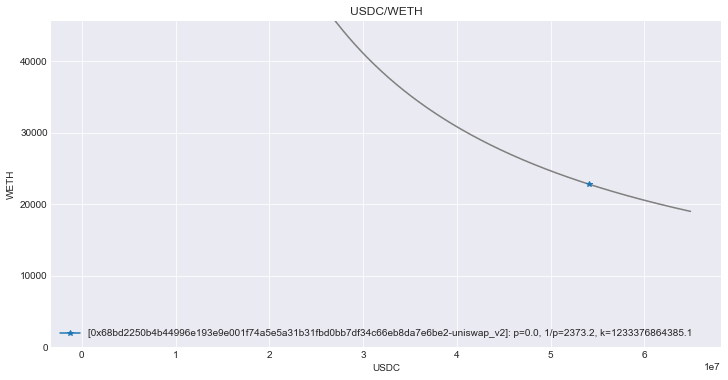

pair = USDC/THOR


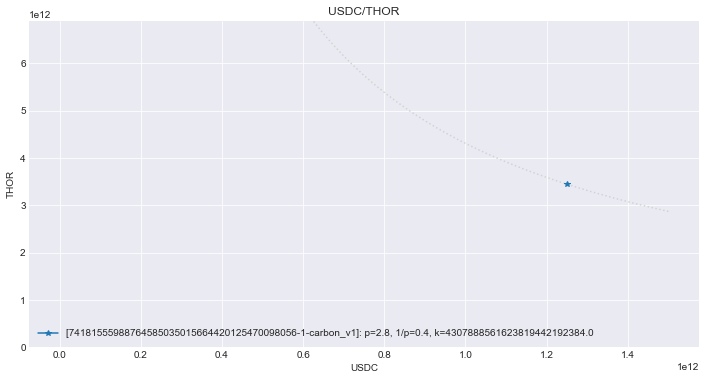

pair = THOR/WETH


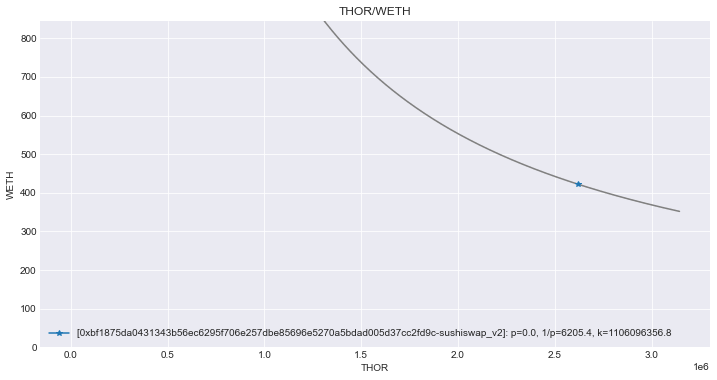

In [127]:
CC.plot()

### Analysis

In [128]:
sgn = [1,-1,-1]
price = dict()
quote = dict()
for c,s in zip(CC, sgn):
    price[c.pair] = c.p
    quotep = f"{c.tkny} per {c.tknx}" if s > 0 else f"{c.tknx} per {c.tkny}"
    print(f"{c.pair} {s} {(c.p)**s} {quotep}")

USDC-eB48/THOR-8044 1 2.754821212121191 THOR-8044 per USDC-eB48
THOR-8044/WETH-6Cc2 -1 6205.376410123059 THOR-8044 per WETH-6Cc2
USDC-eB48/WETH-6Cc2 -1 2373.231732603509 USDC-eB48 per WETH-6Cc2


In [129]:
price

{'USDC-eB48/THOR-8044': 2.754821212121191,
 'THOR-8044/WETH-6Cc2': 0.0001611505787737007,
 'USDC-eB48/WETH-6Cc2': 0.00042136635300378734}

### Carbon curve

Below is the Carbon curve. It **sells THOR** and **buys USDC** at a rate of **0.36 USDC per THOR** (ignoring fees).

In [130]:
p0 = 1/(price["USDC-eB48/THOR-8044"])
p0

0.3629999637000064

In [131]:
print(CC[0].description())

cid      = 098056-1 [74181555988764585035015664420125470098056-1]
primary  = THOR/USDC [THOR-8044/USDC-eB48]
pp       = 0.363000 USDC per THOR
pair     = USDC/THOR [USDC-eB48/THOR-8044]
tknx     =             0.000000 USDC-eB48  [virtual: 1,250,505,254,484.410]
tkny     =       344,491.806153 THOR-8044  [virtual: 3,444,918,400,922.661]
p        = 2.754821212121191 [min=2.7548206611570305, max=2.754821212121191] THOR-8044 per USDC-eB48
fee      = 2000.0
descr    = carbon_v1 THOR-8044/USDC-eB48 2000



Ignoring slippage and fees, it is possible to buy and sell THOR AT 0.38 USDC per THOR via the two provided curves.

In [132]:
p1 = 1/(price["USDC-eB48/WETH-6Cc2"] / price["THOR-8044/WETH-6Cc2"])
p1

0.3824476672731679

That's an arbitrage opportunity (Buy THOR against USDC on Carbon, sell into the arb) of about 5% meaning that at least in small size (ie before slippage) it should work

In [133]:
p1/p0-1

0.05357494633039028

### Triangle curves

The triangle curves are the following

- **THOR/WETH** has 422 ETH and 2.6m THOR at a price of 6205 THOR per ETH
- **WETH/USDC** has 23k ETH and 50m USDC at a price of 2373 USDC per ETH

The implied **THOR** price is 0.382 USDC (memo: on Carbon it is 0.362, and the THOR loading is 344k, ie ~15% of the THOR-8044 available on the arb curve)

In [134]:
p1, p0, p1/p0-1, 344/2600

(0.3824476672731679,
 0.3629999637000064,
 0.05357494633039028,
 0.13230769230769232)

In [135]:
print(CC[1].description())

cid      = 7cc2fd9c [0xbf1875da0431343b56ec6295f706e257dbe85696e5270a5bdad005d37cc2fd9c]
primary  = THOR/WETH [THOR-8044/WETH-6Cc2]
pp       = 0.000161 WETH per THOR
pair     = THOR/WETH [THOR-8044/WETH-6Cc2]
tknx     =     2,619,874.851941 THOR-8044  [virtual:        2,619,874.852]
tkny     =           422.194349 WETH-6Cc2  [virtual:              422.194]
p        = 0.0001611505787737007 [min=0, max=None] WETH-6Cc2 per THOR-8044
fee      = 0.003
descr    = sushiswap_v2 THOR-8044/WETH-6Cc2 0.003



In [136]:
1/0.0001611505787737007

6205.376410123059

In [137]:
print(CC[2].description())

cid      = da7e6be2 [0x68bd2250b4b44996e193e9e001f74a5e5a31b31fbd0bb7df34c66eb8da7e6be2]
primary  = WETH/USDC [WETH-6Cc2/USDC-eB48]
pp       = 2,373.231733 USDC per WETH
pair     = USDC/WETH [USDC-eB48/WETH-6Cc2]
tknx     =    54,102,579.539405 USDC-eB48  [virtual:       54,102,579.539]
tkny     =        22,797.006629 WETH-6Cc2  [virtual:           22,797.007]
p        = 0.00042136635300378734 [min=0, max=None] WETH-6Cc2 per USDC-eB48
fee      = 3000.0
descr    = uniswap_v2 USDC-eB48/WETH-6Cc2 0.003



In [138]:
1/0.00042136635300378734

2373.231732603509

## Optimizer

In [139]:
help(MargPOptimizer.optimize)

Help on function optimize in module tools.optimizer.margpoptimizer:

optimize(self, sfc=None, result=None, *, params=None)
    optimal transactions across all curves in the optimizer, extracting targettkn*
    
    :sfc:           the self financing constraint to use**
    :result:        the result type
                        :MO_DEBUG:         a number of items useful for debugging
                        :MO_PSTART:        price estimates (as dataframe)
                        :MO_PE:            alias for MO_ESTPRICE
                        :MO_DTKNFROMPF:    the function calculating dtokens from p
                        :MO_MINIMAL:       minimal result (omitting some big fields)
                        :MO_FULL:          full result
                        :None:             alias for MO_FULL
    :params:        dict of parameters
                        :crit:             criterion MOCRITR (relative, default) or MOCRITA (absolute)
                        :norm:             norm

### Raw run

This is the actual run, using USDC as the arbitrage token. This run does not converge; rather the THOR-8044/USDC-eB48 price oscillates between 0.38ish and 0.29ish. Note that this is way out of the (imputed) price range for the Carbon range which is very tightly centered around `p0~0.36`

(uncomment the below code to see the debug run)

In [140]:
O = MargPOptimizer(CC)
r = O.optimize("USDC-eB48", params=dict(verbose=False, debug=False))
#O.optimize("USDC", params=dict(verbose=True, debug=True))
r

CPCArbOptimizer.MargpOptimizerResult(result=None, time=0.01725602149963379, method='margp', targettkn='USDC-eB48', p_optimal_t=None, dtokens_t=None, tokens_t=('THOR-8044', 'WETH-6Cc2'), errormsg=ConvergenceError('maximum number of iterations reached [49]'))

In [141]:
#r = O.optimize("USDC", params=dict(verbose=True, debug=True))
#r

### Better prices estimates

We set the initial price for THOR/USD squat into the Carbon range to see whether this works better. 

TLDR -- it does not.

In [142]:
price_est = {
    "USDC-eB48": 1,
    "WETH-6Cc2": 2373.2,
    "THOR-8044": p0,
}
price_est

{'USDC-eB48': 1, 'WETH-6Cc2': 2373.2, 'THOR-8044': 0.3629999637000064}

In [143]:
O = MargPOptimizer(CC)
r = O.optimize("USDC-eB48", params=dict(pstart=price_est, verbose=False, debug=False))
#O.optimize("USDC", params=dict(pstart=price_est, verbose=True, debug=True))
r

CPCArbOptimizer.MargpOptimizerResult(result=None, time=0.014834880828857422, method='margp', targettkn='USDC-eB48', p_optimal_t=None, dtokens_t=None, tokens_t=('THOR-8044', 'WETH-6Cc2'), errormsg=ConvergenceError('maximum number of iterations reached [49]'))

#### Tighter Jacobian

Currently the jacobian h is set to 1e-5 and `minrw` in the data provided is set to 1e-7 meaning that the Jacobian calculation goes outside the concentrated liquidity area and is therefore much too steep.

We'll try 1e-8 as `jach` here. Turns out this works and it even converges. 

In [144]:
CC[0].p_max/CC[0].p_min-1

2.0000001033082526e-07

In [168]:
O = MargPOptimizer(CC)
r = O.optimize("USDC-eB48", params=dict(pstart=price_est, verbose=False, debug=False, jach=1e-8))
#O.optimize("USDC", params=dict(pstart=price_est, verbose=True, debug=True))
r

CPCArbOptimizer.MargpOptimizerResult(result=-652.6409813463688, time=0.003238201141357422, method='margp', targettkn='USDC-eB48', p_optimal_t=(0.36299997803167783, 2371.00929814847), dtokens_t=(0.0003078095614910126, 7.815970093361102e-11), tokens_t=('THOR-8044', 'WETH-6Cc2'), errormsg=None)

In [167]:
# CCr.plot()

In [165]:
# O = MargPOptimizer(CCr)
# r = O.optimize("USDC-eB48", params=dict(verbose=False, debug=False))
# O.optimize("USDC-eB48", params=dict(verbose=True, debug=True))
# r

In [147]:
# p2 = r.p_optimal["THOR-8044"]
# p2

0.363000235520445

In [148]:
# p2/p0-1

7.488167101943333e-07

In [166]:
# r.dtokens

#### Absolute convergence criteria

In [150]:
#O.optimize("USDC-eB48", result=O.MO_PSTART)

In [151]:
pstart = {'WETH-6Cc2': 2373.231732603511, 'THOR-8044': 0.36299996370000637, 'USDC-eB48': 1, "USD": 1}
params = dict(crit=O.MOCRITA, norm=O.MONORMLINF, epsa=10, epsaunit="USD", pstart=pstart)
r = O.optimize("USDC-eB48", params=dict(verbose=False, debug=False))
#O.optimize("USDC-eB48", params=dict(verbose=True, debug=True, **params))
r

CPCArbOptimizer.MargpOptimizerResult(result=109076.49614349008, time=0.0017580986022949219, method='margp', targettkn='USDC-eB48', p_optimal_t=(0.363000235520445, 2371.009327956787), dtokens_t=(-302284.11119448347, -5.535582658922067e-09), tokens_t=('THOR-8044', 'WETH-6Cc2'), errormsg=None)

### Removing the Carbon curve

Here we check how it converges if we remove the Carbon curve and replace it with a constant product curve of the same (virtual) capacity. Unsurprisingly it does and all dtokens are zero.

In [152]:
c0 = CC[0]
c0b = CPC.from_xy(x=c0.x, y=c0.y, pair=c0.pair)
c0b

ConstantProductCurve(k=4.3078885616238194e+24, x=1250505254484.4102, x_act=1250505254484.4102, y_act=3444918400922.661, alpha=0.5, pair='USDC-eB48/THOR-8044', cid='None', fee=None, descr=None, constr='xy', params={})

pair = USDC/WETH


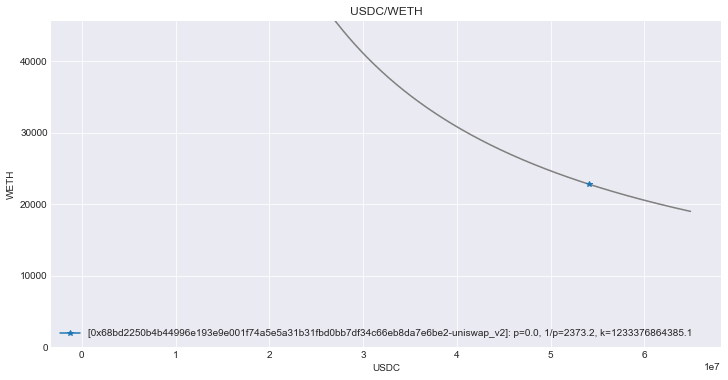

pair = USDC/THOR


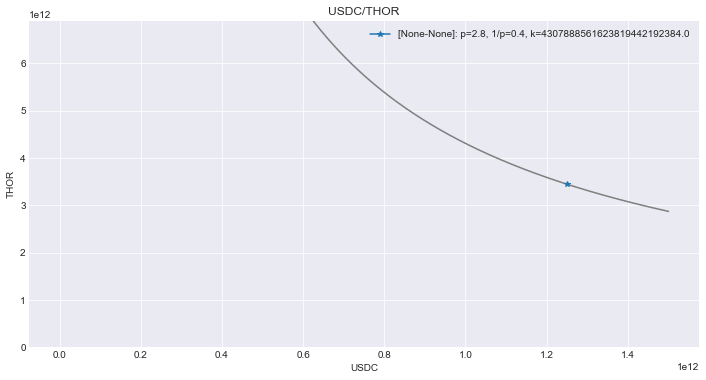

pair = THOR/WETH


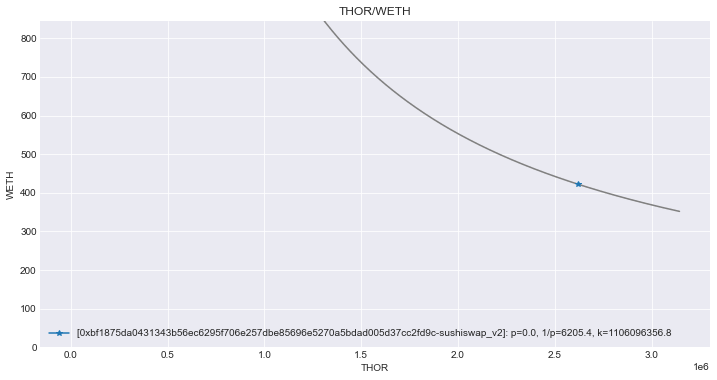

In [153]:
CCb = CPCContainer.from_dicts(curves_as_dicts[1:])
CCb += c0b
CCb.plot()

In [154]:
O = MargPOptimizer(CCb)
r = O.optimize("USDC-eB48", params=dict(verbose=False, debug=False))
#O.optimize("USDC", params=dict(verbose=True, debug=True))
r

CPCArbOptimizer.MargpOptimizerResult(result=-652.6406125426292, time=0.0007507801055908203, method='margp', targettkn='USDC-eB48', p_optimal_t=(0.36299997803167794, 2371.0092981594016), dtokens_t=(-0.000662557315081358, -5.344651299310499e-08), tokens_t=('THOR-8044', 'WETH-6Cc2'), errormsg=None)

In [155]:
r.dtokens

{'USDC-eB48': -652.6406125426292,
 'THOR-8044': -0.000662557315081358,
 'WETH-6Cc2': -5.344651299310499e-08}

#### Absolute convergence criteria

In [156]:
#O.optimize("USDC-eB48", result=O.MO_PSTART)

In [157]:
pstart = {'WETH-6Cc2': 2373.231732603511, 'THOR-8044': 0.36299996370000637, 'USDC-eB48': 1, "USD": 1}
params = dict(crit=O.MOCRITA, norm=O.MONORMLINF, epsa=10, epsaunit="USD", pstart=pstart)
r = O.optimize("USDC-eB48", params=dict(verbose=False, debug=False))
#O.optimize("USDC-eB48", params=dict(verbose=True, debug=True, **params))
r

CPCArbOptimizer.MargpOptimizerResult(result=-652.6406125426292, time=0.0007500648498535156, method='margp', targettkn='USDC-eB48', p_optimal_t=(0.36299997803167794, 2371.0092981594016), dtokens_t=(-0.000662557315081358, -5.344651299310499e-08), tokens_t=('THOR-8044', 'WETH-6Cc2'), errormsg=None)

## Unit tests

In [158]:
def iseq(arg0, *args, eps=1e-6):
    """checks whether all arguments are equal to arg0, within tolerance eps if numeric"""
    if not args:
        raise ValueError("Must provide at least one arg", args)
    try:
        arg0+1
        isnumeric = True
    except:
        isnumeric = False
    #if isinstance(arg0, int) or isinstance(arg0, float):
    if isnumeric:
        # numeric testing
        if arg0 == 0:
            for arg in args:
                if abs(arg) > eps: 
                    return False
                return True
        for arg in args:
            if abs(arg/arg0-1) > eps:
                return False
            return True
    else:
        for arg in args:
            if not arg == arg0:
                return False
        return True

def raises(func, *args, **kwargs):
    """
    returns exception message if func(*args, **kwargs) raises, else False

    USAGE

        assert raises(func, 1, 3, three=3), "func(1, 2, three=3) should raise"
    """
    try:
        func(*args, **kwargs)
        return False
    except Exception as e:
        return str(e)

### CPC min range width functionality

In [159]:
cdata = dict(y=100, yint=100, pa=100, pb=100, pair="WETH-6Cc2/USDC-eB48", tkny="USDC-eB48")
c  = CPC.from_carbon(**cdata)
c2 = CPC.from_carbon(**cdata, minrw=1e-2)
c4 = CPC.from_carbon(**cdata, minrw=1e-4)
c6 = CPC.from_carbon(**cdata, minrw=1e-6)
c

ConstantProductCurve(k=400000399924037.75, x=2000000.4998099068, x_act=0, y_act=100, alpha=0.5, pair='WETH-6Cc2/USDC-eB48', cid='None', fee=None, descr=None, constr='carb', params={'y': 100, 'yint': 100, 'A': 0, 'B': 9.999997500001562, 'pa': 100, 'pb': 100, 'minrw': 1e-06})

In [160]:
assert c2.params.minrw==0.01
assert c4.params.minrw==0.0001
assert c6.params.minrw==0.000001
assert c.params.minrw==0.000001

In [161]:
assert iseq(c2.p**2/100**2, 1.01)
assert iseq(c4.p**2/100**2, 1.0001)
assert iseq(c6.p**2/100**2, 1.000001)
assert iseq(c.p, c6.p)

In [162]:
assert iseq(c2.p-100, 0.49875621120, eps=1e-3)
assert iseq(c4.p-100, 0.00499987500, eps=1e-3)
assert iseq(c6.p-100, 0.00004999875, eps=1e-3)
assert iseq((c2.p-100)/(c4.p-100), 99.75373596136635, eps=1e-4)
assert iseq((c4.p-100)/(c6.p-100), 99.99752507444194, eps=1e-4)

### margpoptimizer absolute convergence

In [163]:
cdata = dict(y=100, yint=100, pa=100, pb=100, pair="WETH-6Cc2/USDC-eB48", tkny="USDC-eB48")
c  = CPC.from_carbon(**cdata)
O = MargPOptimizer(CPCContainer([c,c]))
r = O.optimize("USDC-eB48", params=dict(verbose=True, debug=True), result=O.MO_DEBUG)
assert r["crit"]["crit"] is None
assert r["crit"]["eps"] == O.MOEPS
assert r["crit"]["epsa"] == O.MOEPSA
assert r["crit"]["epsaunit"] == O.MOEPSAUNIT
assert r["crit"]["pstart"] is None

In [164]:
assert raises(O.optimize, "USDC-eB48", params=dict(crit="meh")) ==\
  'crit must be MOCRITR or MOCRITA'
assert raises(O.optimize, "USDC-eB48", params=dict(crit=O.MOCRITA)) == \
  "pstart must be provided if crit is MOCRITA"
assert raises(O.optimize, "USDC-eB48", params=dict(crit=O.MOCRITA, pstart=dict(FOO=1))) ==\
  "epsaunit USD not in pstart {'FOO': 1}"

AssertionError: 

In [ ]:
raises(O.optimize, "USDC-eB48", params=dict(crit=O.MOCRITA, pstart=dict(FOO=1)))

In [ ]:
O.optimize("USDC-eB48", params=dict(crit=O.MOCRITA, pstart=dict(FOO=1)))

In [ ]:
r = O.optimize("USDC-eB48", params=dict(
    crit = O.MOCRITA,
    eps = 1e-10,
    epsa = 100,
    epsaunit = "dollah",
    pstart = dict(dollah=1, WETH=2000, USDC=1)
), result=O.MO_DEBUG)
assert r["crit"]["crit"] == O.MOCRITA
assert r["crit"]["eps"] == 1e-10
assert r["crit"]["epsa"] == 100
assert r["crit"]["epsaunit"] == "dollah"
assert r["crit"]["pstart"] == dict(dollah=1, WETH=2000, USDC=1)

In [ ]:
print(np.inf)